# Synthesizing Handwritten Digits from the MNIST Dataset using Conditional Generative Adversarial Networks (GANs)

This notebook is a simple demonstration of how conditional Generative Adversarial Networks (GANs) work.  We use the MNIST handwritten digit dataset and a dense MLP-style architecture for both the generator and descriminator.  We also condition the generator by passing the class label as an input and the discriminator by having it predict one of 11 labels: 0-9 or fake.  Note that adding class conditioning makes it much easier to generate realistic looking images.

This notebook is very similar to my previous demonstration of GANs except that we now condition the process using the class labels.  This is intended to be a very basic demonstration of conditioned GANs.  See my other notebooks for more sophisticated examples using convolutional networks.

In [1]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (11, 11)

In [2]:
import functools
import gzip
import operator
import random
import struct

import tqdm.notebook as tqdm
import munch

import skimage as ski
import matplotlib.pyplot as plt
import numpy as np
import torch as th

## MNIST Dataset

In [3]:
class MNIST(th.utils.data.Dataset):
    '''Simple MNIST dataset with labels.
    '''
    def __init__(self):
        '''Initialize a new MNIST dataset.
        '''
        super().__init__()
        self.imgs, self.labels = self._load_imgs()
        
    @staticmethod
    def _load_imgs():
        '''Load all of the training images and labels.  This dataset is relatively small,
        so we just keep everything in memory on the CPU side.

        Thanks:
            https://stackoverflow.com/questions/39969045/parsing-yann-lecuns-mnist-idx-file-format
        '''
        with gzip.open('../data/torchvision/MNIST/raw/train-images-idx3-ubyte.gz', mode='rb') as fh:
            _magic, size = struct.unpack('>II', fh.read(8))
            nrows, ncols = struct.unpack('>II', fh.read(8))
            data = np.frombuffer(fh.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))
            imgs = data.reshape((size, nrows, ncols)) / 255.
                
        with gzip.open('../data/torchvision/MNIST/raw/train-labels-idx1-ubyte.gz', mode='rb') as fh:
            _magic, _size = struct.unpack('>II', fh.read(8))
            labels = np.frombuffer(fh.read(), dtype=np.dtype(np.uint8).newbyteorder('>')) + 1

        return th.as_tensor(imgs, dtype=th.float32), th.as_tensor(labels, dtype=th.int64)

    def __getitem__(self, idx):
        '''Return a tuple containing a single image and the
        corresponding label at the given index.
        '''
        return self.imgs[idx], self.labels[idx]
    
    def __len__(self):
        '''Return the number of images in the dataset.
        '''
        return self.imgs.shape[0]
    
    def plot(self, idx):
        '''Plot the image specified by the given index.
        '''
        fig, ax = plt.subplots()
        ax.imshow(self.imgs[idx], cmap=plt.cm.gray)
        ax.axis('off')
        
        return munch.Munch(fig=fig, ax=ax)
        
    def plot_montage(self, n=36, seed=42):
        '''Plot a montage of `n` randomly selected images.
        '''
        rng = random.Random(seed)
        idxs = rng.sample(range(len(self)), n)

        imgs = th.stack([self[idx][0] for idx in idxs], dim=0)
        montage = ski.util.montage(imgs)
        
        fig, ax = plt.subplots()
        ax.imshow(montage, cmap=plt.cm.gray)
        ax.axis('off')
        
        return munch.Munch(fig=fig, ax=ax)

In [4]:
data = MNIST()
len(data)

60000

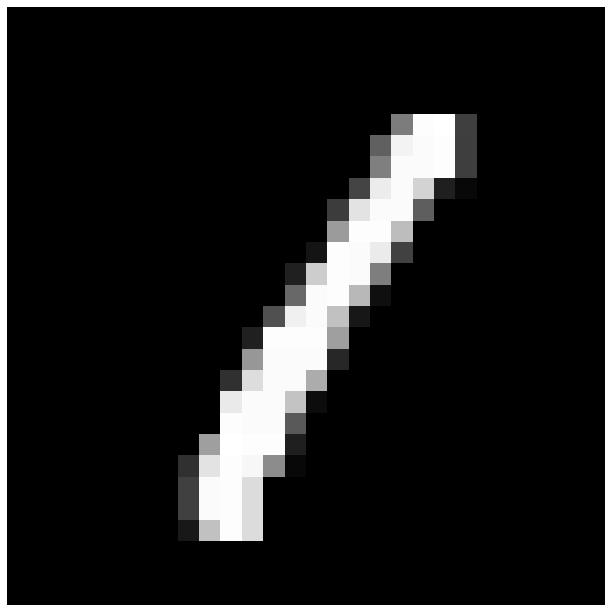

In [5]:
data.plot(3);

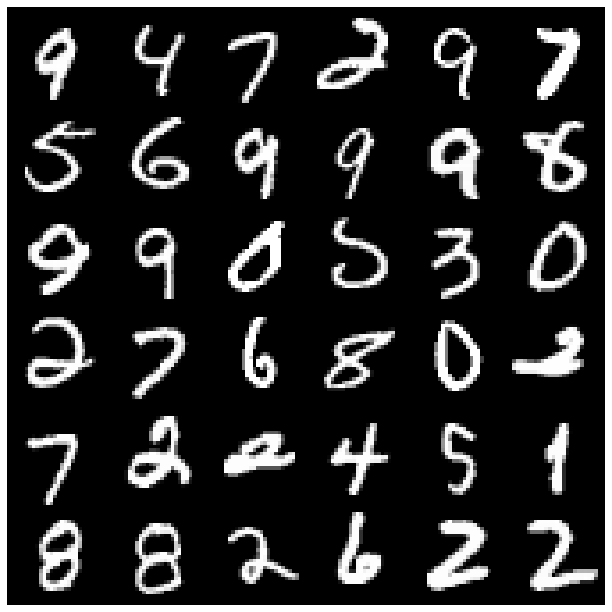

In [6]:
data.plot_montage();

## Generator

In [7]:
class _Tanh(th.nn.Module):
    '''Hyperbolic tangent, scaled as described in Lecun's backprop tricks paper.
    '''
    def __init__(self):
        super().__init__()
        self.register_buffer('_a', th.as_tensor(1.7159), persistent=False)
        self.register_buffer('_b', th.as_tensor(2. / 3.), persistent=False)

    def forward(self, x):
        return self._a * th.tanh(self._b * x)

In [8]:
class _Linear(th.nn.Linear):
    '''Dense linear layer with linear Kaiming weight initialization.
    '''
    def reset_parameters(self):
        th.nn.init.kaiming_normal_(self.weight, nonlinearity='linear')
        if hasattr(self, 'bias'):
            th.nn.init.zeros_(self.bias)

In [9]:
class Generator(th.nn.Module):
    '''MLP-style generator with class label inputs for conditioning.
    '''
    def __init__(self, latent_dim=32, num_labels=10, img_size=(28, 28),
                 layer_specs=(64, 128, 256)):
        '''Initialize a new generator.
        
        latent_dim (int):
            Expected number of dimensions for the input latent vector
            used for generating images.
        num_labels (int):
            Number of input class labels to expect for conditioning.
        img_size (tuple(int)):
            Two-tuple of integers specifying the height and width of
            the output images in pixels.
        layer_specs (tuple(int)):
            A tuple where each value specifies the number of hidden
            units in each layer.  The number of values in this tuple
            determines the number of layers.
        '''
        super().__init__()
        
        self.latent_dim = latent_dim
        self.num_labels = num_labels
        self.img_size = img_size
        
        self.hidden = th.nn.Sequential()
        layer_in, layer_out = None, self.latent_dim + self.num_labels
        for num_units in layer_specs:
            layer_in, layer_out = layer_out, num_units
            self.hidden.append(
                th.nn.Sequential(
                    _Linear(layer_in, layer_out),
                    _Tanh(),
                )
            )

        out_dim = functools.reduce(operator.mul, img_size)
        layer_in, layer_out = layer_out, out_dim
        self.visible = _Linear(layer_in, layer_out)
        
    def forward(self, z, labels):
        '''Forward pass generates synthetic images from
        the latent vector `z` and integer class `labels`.
        '''
        batch_size, latent_dim = z.shape
        assert latent_dim == self.latent_dim

        assert labels.shape == (batch_size,)
        indicators = th.zeros(batch_size, self.num_labels, device=labels.device)
        indicators.scatter_(1, labels[:, None], 1).sub_(0.5)

        x = th.cat((z, indicators), dim=1)
        hidden_out = self.hidden(x)
        visible_out = self.visible(hidden_out)

        return th.sigmoid(visible_out + 0.5).view(batch_size, *self.img_size)
    
    @th.no_grad()
    def plot_montage(self, n=36, label=None):
        '''Plot a montage of `n` synthetic images.  If `labels` is ``None``
        then they will be generated randomly.
        '''
        if label is None:
            labels = th.randint(0, self.num_labels, size=(n,))
        else:
            labels = th.ones(n, dtype=th.int64) * label
        
        z = th.randn(n, self.latent_dim).movedim(1, -1)
        imgs = self(z, labels).cpu()
        
        montage = ski.util.montage(imgs)
        fig, ax = plt.subplots()
        ax.imshow(montage, cmap=plt.cm.gray)
        ax.axis('off')

In [10]:
generator = Generator()
generator

Generator(
  (hidden): Sequential(
    (0): Sequential(
      (0): _Linear(in_features=42, out_features=64, bias=True)
      (1): _Tanh()
    )
    (1): Sequential(
      (0): _Linear(in_features=64, out_features=128, bias=True)
      (1): _Tanh()
    )
    (2): Sequential(
      (0): _Linear(in_features=128, out_features=256, bias=True)
      (1): _Tanh()
    )
  )
  (visible): _Linear(in_features=256, out_features=784, bias=True)
)

In [11]:
sum(p.numel() for p in generator.parameters())

245584

(torch.Size([2, 28, 28]), tensor(0.0957), tensor(0.9459))

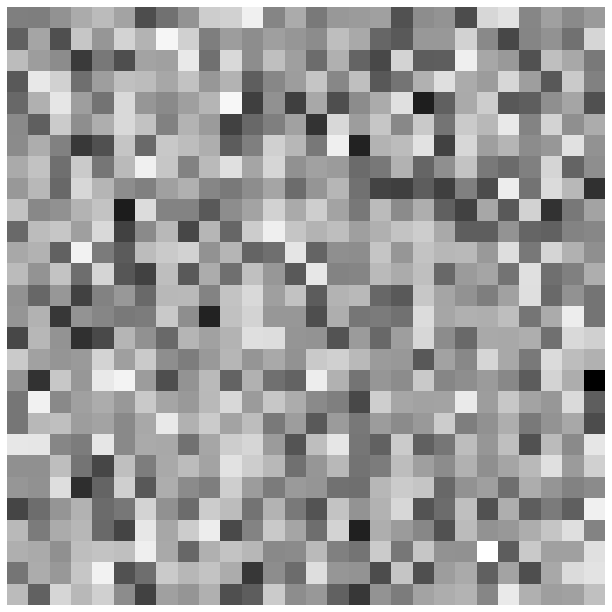

In [12]:
with th.inference_mode():
    labels = th.randint(0, generator.num_labels, size=(2,))
    z = th.randn(2, generator.latent_dim)
    im = generator(z, labels)
plt.imshow(im[0], cmap=plt.cm.gray)
plt.axis('off')
im.shape, im.min(), im.max()

## Discriminator

In [13]:
class Discriminator(th.nn.Module):
    '''MLP-style discriminator with class label conditioning.
    '''
    def __init__(self, img_size=(28, 28), num_classes=11, layer_specs=(256, 128, 64)):
        '''Initialize a new discriminator.

        img_size (tuple(int)):
            Two-tuple of integers specifying the height and width of
            the input images in pixels.
        num_classes (int):
            Number of output class labels, including the "fake" class.
        layer_specs (tuple(int)):
            A tuple where each value specifies the number of hidden
            units in each layer.  The number of values in this tuple
            determines the number of layers.
        '''
        super().__init__()

        self.img_size = img_size
        self.num_classes = num_classes
        self.in_dim = functools.reduce(operator.mul, img_size)

        self.hidden = th.nn.Sequential()
        layer_in, layer_out = None, self.in_dim
        for num_units in layer_specs:
            layer_in, layer_out = layer_out, num_units
            self.hidden.append(
                th.nn.Sequential(
                    _Linear(layer_in, layer_out),
                    _Tanh(),
                )
            )

        layer_in, layer_out = layer_out, self.num_classes
        self.visible = _Linear(layer_in, layer_out)
        
    def forward(self, x):
        '''Forward pass generates predicted class membership
        probabilities for two classes: real and fake.
        '''
        # Means and variances are hard-coded for MNIST
        x = (x - 0.1307) / 0.3081
        
        x = x.flatten(1)
        batch_size, in_dim = x.shape
        assert in_dim == self.in_dim

        return self.visible(self.hidden(x))

In [14]:
discriminator = Discriminator()
discriminator

Discriminator(
  (hidden): Sequential(
    (0): Sequential(
      (0): _Linear(in_features=784, out_features=256, bias=True)
      (1): _Tanh()
    )
    (1): Sequential(
      (0): _Linear(in_features=256, out_features=128, bias=True)
      (1): _Tanh()
    )
    (2): Sequential(
      (0): _Linear(in_features=128, out_features=64, bias=True)
      (1): _Tanh()
    )
  )
  (visible): _Linear(in_features=64, out_features=11, bias=True)
)

In [15]:
sum(p.numel() for p in discriminator.parameters())

242827

In [16]:
with th.inference_mode():
    logits = discriminator(im)
th.sigmoid(logits)

tensor([[0.4468, 0.5329, 0.6601, 0.3782, 0.5661, 0.6311, 0.3450, 0.8174, 0.7734,
         0.3526, 0.6550],
        [0.5054, 0.6017, 0.6865, 0.1826, 0.5484, 0.4862, 0.2787, 0.8323, 0.8051,
         0.2885, 0.7141]])

## Adversarial Training

In [17]:
def train(generator, discriminator, data, epochs=100, batch_size=256, lr=0.001,
          lr_decay=0.98, device=0):
    '''Perform class-conditioned adversarial training for the given `generator`,
    `discriminator` and `data`.
    
    generator (torch.Module):
        The generator module should take a batch of random latent vectors as
        inputs and produce a batch images as outputs.
    discriminator (torch.Module):
        The discriminator should take a batch of images as inputs and assign
        a binary class labels, fake or real, as outputs.
    data (torch.utils.data.Dataset):
        A Torch dataset that produces greyscale images in HW format.
    epochs (int):
        The number of training epochs.
    batch_size (int):
        The batch size.
    lr (float):
        The learning rate to use.
    lr_decay (float):
        Exponential decay rate for the learning rate, applied after
        each training epoch.
    device (int):
        The GPU device ID to use.
    '''
    generator.to(device)
    discriminator.to(device)

    generator.train()
    discriminator.train()
    
    g_opt = th.optim.RMSprop(generator.parameters(), lr=lr)
    d_opt = th.optim.RMSprop(discriminator.parameters(), lr=lr)
    
    g_sched = th.optim.lr_scheduler.ExponentialLR(g_opt, gamma=lr_decay)
    d_sched = th.optim.lr_scheduler.ExponentialLR(d_opt, gamma=lr_decay)
    
    g_losses, d_losses = [], []
    
    dataloader = th.utils.data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True)

    for epoch in tqdm.trange(epochs):
        for imgs, labels in dataloader:
            real_imgs = imgs.to(device, non_blocking=True)
            real_targs = labels.to(device, non_blocking=True)
            fake_targs = th.zeros(batch_size, dtype=th.int64, device=device)

            ## Generator

            rand_targs = th.randint(
                1, discriminator.num_classes, size=(batch_size,))
            rand_targs = rand_targs.to(device, non_blocking=True)

            z = th.randn(batch_size, generator.latent_dim, device=device)
            fake_imgs = generator(z, rand_targs - 1)

            g_loss = th.nn.functional.cross_entropy(
                discriminator(fake_imgs), rand_targs)

            g_losses.append(g_loss.item())

            g_opt.zero_grad()
            g_loss.backward()
            g_opt.step()

            ## Discriminator

            with th.no_grad():
                z = th.randn(batch_size, generator.latent_dim, device=device)
                fake_imgs = generator(z, real_targs - 1)

            fake_loss = th.nn.functional.cross_entropy(
                discriminator(fake_imgs), fake_targs)
            real_loss = th.nn.functional.cross_entropy(
                discriminator(real_imgs), real_targs)  
            d_loss = (fake_loss + real_loss) / 2.
            
            d_losses.append(d_loss.item())

            d_opt.zero_grad()
            d_loss.backward()            
            d_opt.step()

        g_sched.step()
        d_sched.step()
            
    generator.eval()
    discriminator.eval()
    
    generator.cpu()
    discriminator.cpu()
    
    return munch.Munch(
        g_losses=g_losses,
        d_losses=d_losses,
    )

In [18]:
result = train(generator, discriminator, data, epochs=250, batch_size=256, lr=0.001, device=1)

  0%|          | 0/250 [00:00<?, ?it/s]

## Results

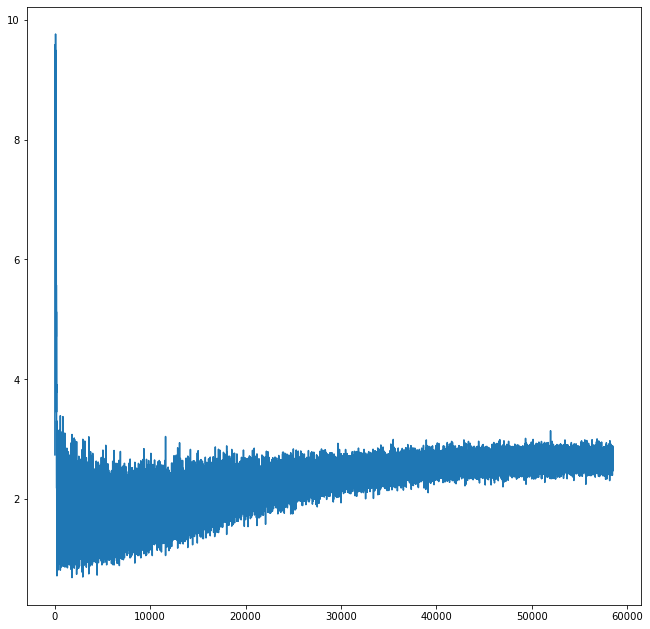

In [19]:
plt.plot(result.g_losses);

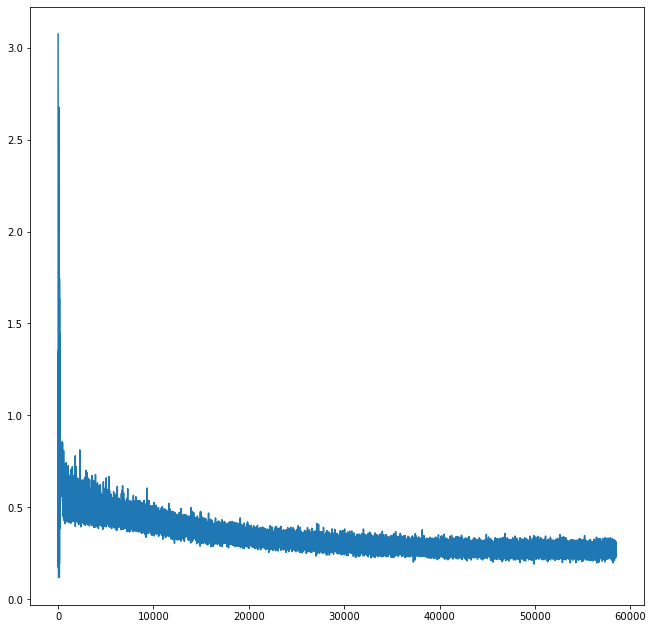

In [20]:
plt.plot(result.d_losses);

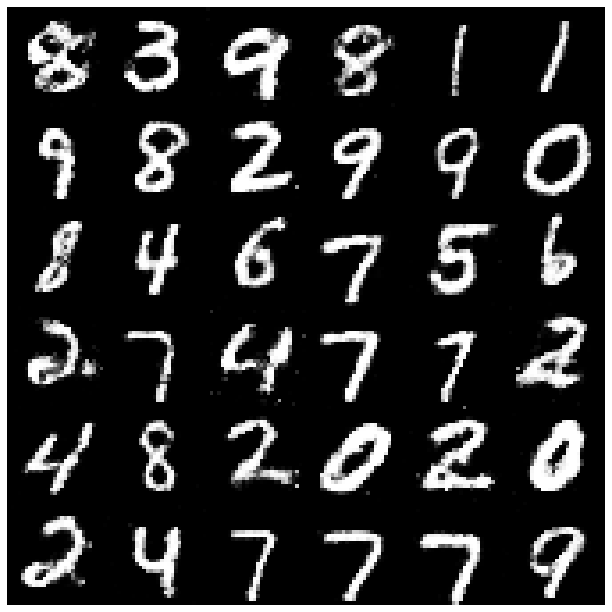

In [21]:
generator.plot_montage()

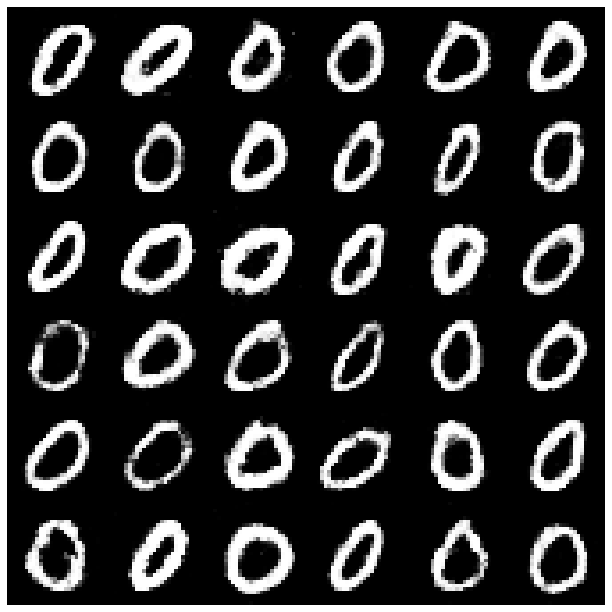

In [22]:
generator.plot_montage(label=0)

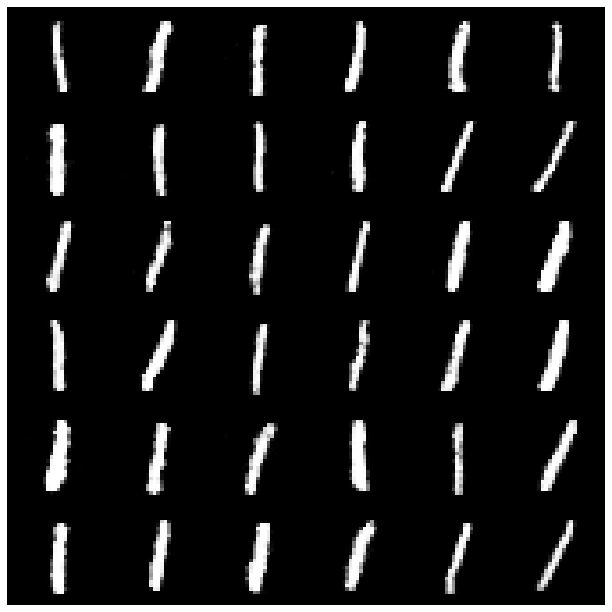

In [23]:
generator.plot_montage(label=1)

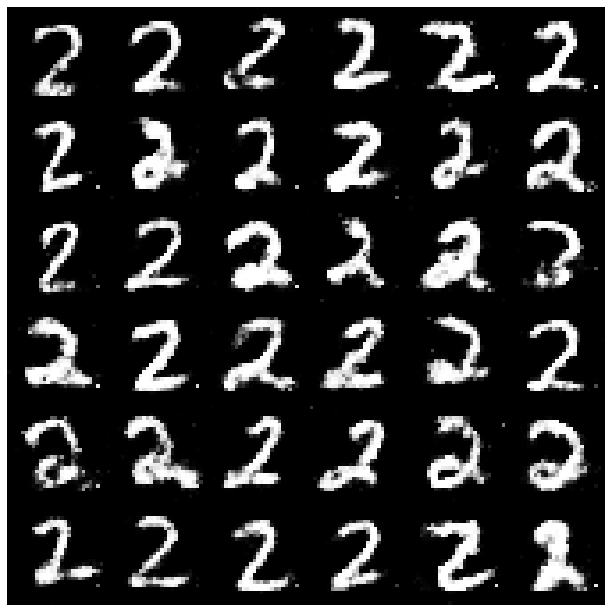

In [24]:
generator.plot_montage(label=2)

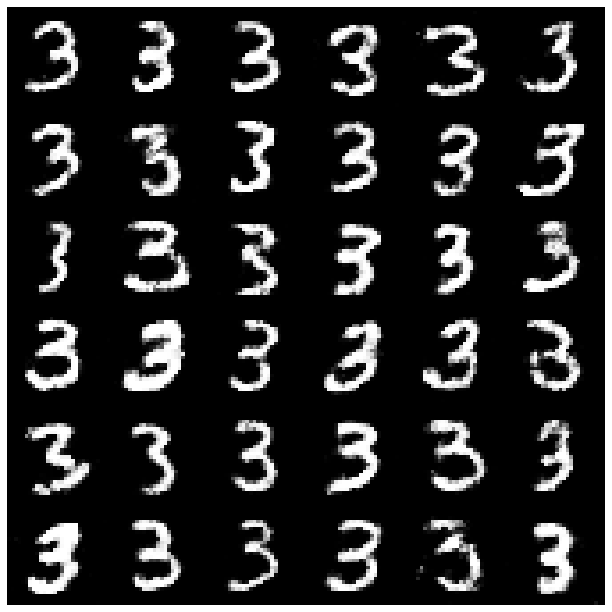

In [25]:
generator.plot_montage(label=3)

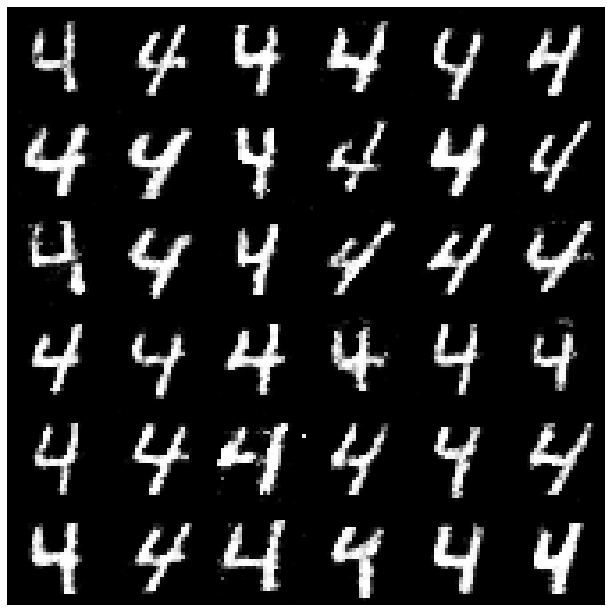

In [26]:
generator.plot_montage(label=4)

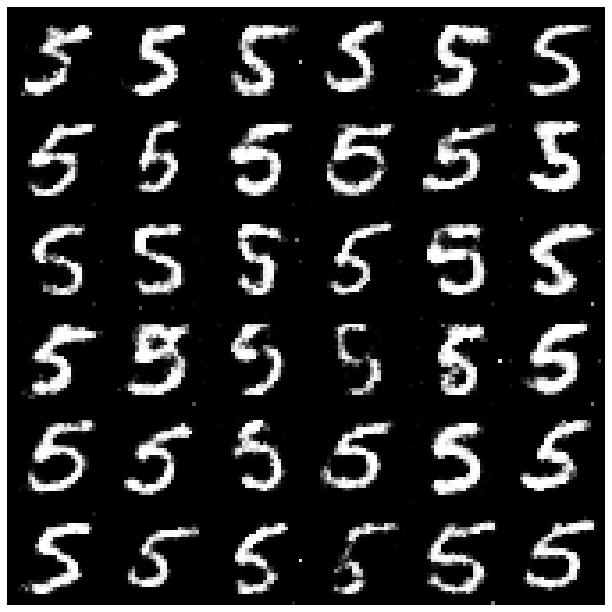

In [27]:
generator.plot_montage(label=5)

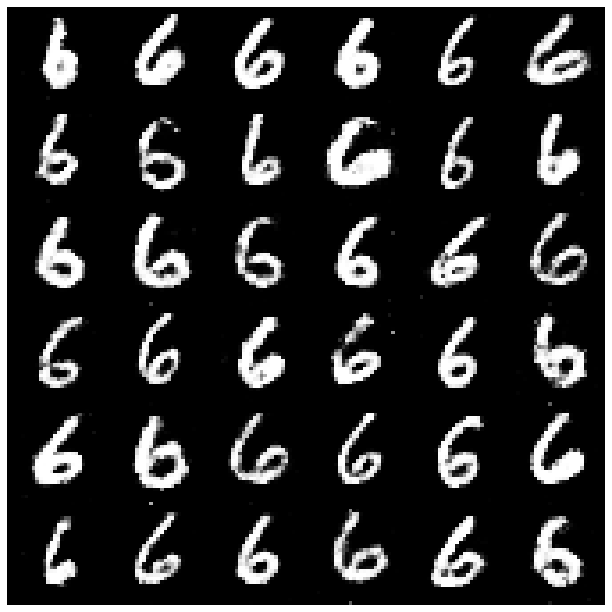

In [28]:
generator.plot_montage(label=6)

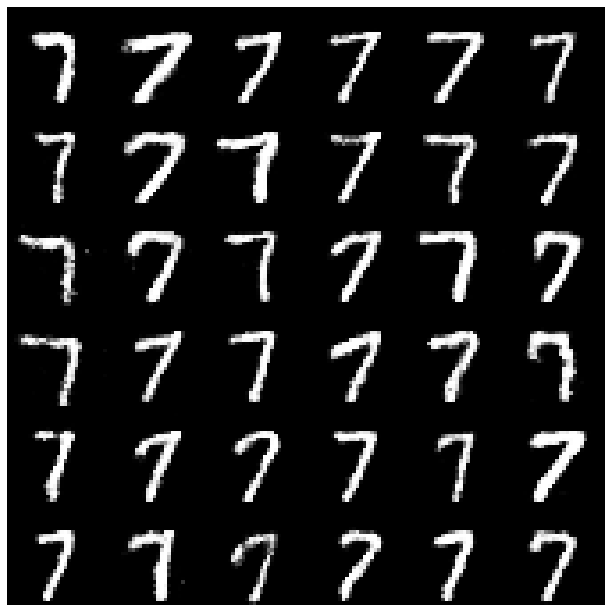

In [29]:
generator.plot_montage(label=7)

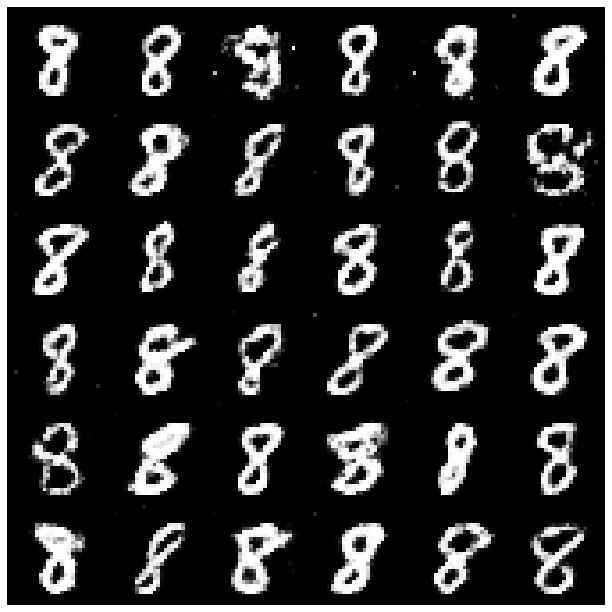

In [30]:
generator.plot_montage(label=8)

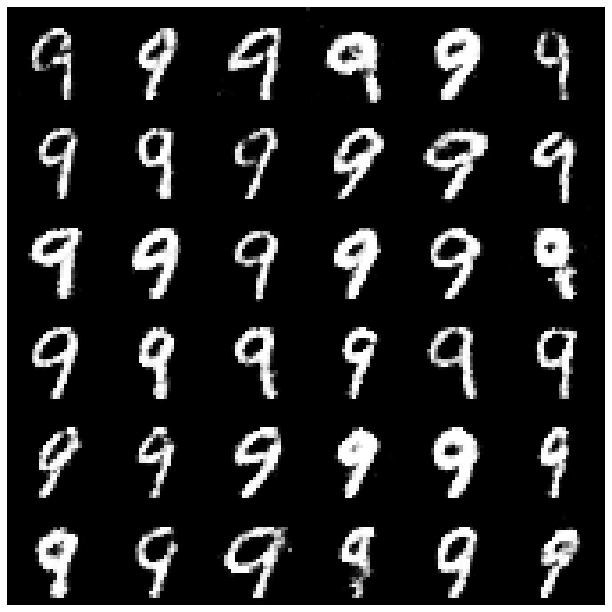

In [31]:
generator.plot_montage(label=9)